In [1]:
from cryptography.hazmat.primitives.asymmetric import rsa, ec, padding
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
import os

### 🔹 Step 1: Receiver Generates Keys (UNCHANGED)
def generate_receiver_keys():
    """Generates RSA and ECC key pairs for the receiver."""
    private_rsa = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048
    )
    public_rsa = private_rsa.public_key()

    private_ecc = ec.generate_private_key(ec.SECP256R1())
    public_ecc = private_ecc.public_key()

    return private_rsa, public_rsa, private_ecc, public_ecc

### 🔹 Step 2: Sender Derives AES Key with ECDH + HKDF (FIXED)
def generate_shared_secret(private_ecc_sender, public_ecc_receiver):
    """Computes ECDH shared secret and derives AES key using HKDF."""
    shared_secret = private_ecc_sender.exchange(ec.ECDH(), public_ecc_receiver)
    
    # Secure key derivation with HKDF
    hkdf = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b'hybrid_file_encryption',
    )
    return hkdf.derive(shared_secret)

### 🔹 Step 3: Encrypt AES Key with RSA (UNCHANGED)
def encrypt_aes_key(aes_key, public_rsa_receiver):
    """Encrypts the AES key using RSA-OAEP."""
    return public_rsa_receiver.encrypt(
        aes_key,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )

### 🔹 Step 4: Encrypt File with AES-GCM (UNCHANGED)
def encrypt_file(file_path, aes_key):
    """Encrypts a file using AES-GCM."""
    iv = os.urandom(12)
    cipher = Cipher(algorithms.AES(aes_key), modes.GCM(iv))
    encryptor = cipher.encryptor()

    with open(file_path, "rb") as f:
        plaintext = f.read()

    ciphertext = encryptor.update(plaintext) + encryptor.finalize()
    return iv, encryptor.tag, ciphertext

### 🔹 Step 5: Decrypt AES Key with RSA (UNCHANGED)
def decrypt_aes_key(encrypted_aes_key, private_rsa_receiver):
    """Decrypts AES key using RSA private key."""
    return private_rsa_receiver.decrypt(
        encrypted_aes_key,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )

### 🔹 Step 6: Decrypt File with AES-GCM (UNCHANGED)
def decrypt_file(encrypted_data, aes_key, iv, tag):
    """Decrypts file using AES-GCM."""
    cipher = Cipher(algorithms.AES(aes_key), modes.GCM(iv, tag))
    decryptor = cipher.decryptor()
    return decryptor.update(encrypted_data) + decryptor.finalize()

### 🔹 Full Secure Workflow with FIXES
def main():
    # ➤ Receiver Setup
    private_rsa, public_rsa, private_ecc, public_ecc = generate_receiver_keys()

    # ➤ Sender Setup
    sender_ecc_private = ec.generate_private_key(ec.SECP256R1())  # Ephemeral key
    sender_ecc_public = sender_ecc_private.public_key()

    # ➤ Sender: Derive AES Key via ECDH
    aes_key_sender = generate_shared_secret(sender_ecc_private, public_ecc)

    # ➤ Sender: Encrypt AES Key with RSA
    encrypted_aes_key = encrypt_aes_key(aes_key_sender, public_rsa)

    # ➤ Sender: Prepare test file
    file_path = "test_file.txt"
    with open(file_path, "w") as f:
        f.write("Secure hybrid encryption test!")

    # ➤ Sender: Encrypt File
    iv, tag, ciphertext = encrypt_file(file_path, aes_key_sender)

    # ➤ Simulate Transmission: Send these to receiver
    transmission_data = {
        "encrypted_aes_key": encrypted_aes_key,
        "sender_ecc_public": sender_ecc_public.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ),
        "iv": iv,
        "tag": tag,
        "ciphertext": ciphertext
    }

    # ➤ Receiver: Decrypt AES Key with RSA
    decrypted_aes_key = decrypt_aes_key(
        transmission_data["encrypted_aes_key"], private_rsa
    )

    # ➤ Receiver: Re-derive AES Key via ECDH (CRITICAL FIX)
    # Deserialize sender's public key
    sender_public_ecc = serialization.load_pem_public_key(
        transmission_data["sender_ecc_public"]
    )
    
    # Recompute shared secret and AES key
    aes_key_receiver = generate_shared_secret(private_ecc, sender_public_ecc)

    # Validate keys match (MITM prevention)
    if decrypted_aes_key != aes_key_receiver:
        raise ValueError("AES Key Mismatch! Potential MITM attack detected.")

    # ➤ Receiver: Decrypt File
    decrypted_data = decrypt_file(
        transmission_data["ciphertext"],
        aes_key_receiver,
        transmission_data["iv"],
        transmission_data["tag"]
    )

    # Save decrypted file
    with open("decrypted_file.txt", "wb") as f:
        f.write(decrypted_data)

    print("✅ Secure hybrid encryption/decryption successful!")

if __name__ == "__main__":
    main()

✅ Secure hybrid encryption/decryption successful!


Testing 1 KB...
Testing 2 KB...
Testing 3 KB...
Testing 4 KB...
Testing 5 KB...
Testing 6 KB...
Testing 7 KB...
Testing 8 KB...
Testing 9 KB...
Testing 10 KB...
Testing 11 KB...
Testing 12 KB...
Testing 13 KB...
Testing 14 KB...
Testing 15 KB...
Testing 16 KB...
Testing 17 KB...
Testing 18 KB...
Testing 19 KB...
Testing 20 KB...
Testing 21 KB...
Testing 22 KB...
Testing 23 KB...
Testing 24 KB...
Testing 25 KB...
Testing 26 KB...
Testing 27 KB...
Testing 28 KB...
Testing 29 KB...
Testing 30 KB...
Testing 31 KB...
Testing 32 KB...
Testing 33 KB...
Testing 34 KB...
Testing 35 KB...
Testing 36 KB...
Testing 37 KB...
Testing 38 KB...
Testing 39 KB...
Testing 40 KB...
Testing 41 KB...
Testing 42 KB...
Testing 43 KB...
Testing 44 KB...
Testing 45 KB...
Testing 46 KB...
Testing 47 KB...
Testing 48 KB...
Testing 49 KB...
Testing 50 KB...
Testing 55 KB...
Testing 60 KB...
Testing 65 KB...
Testing 70 KB...
Testing 75 KB...
Testing 80 KB...
Testing 85 KB...
Testing 90 KB...
Testing 95 KB...
Testin

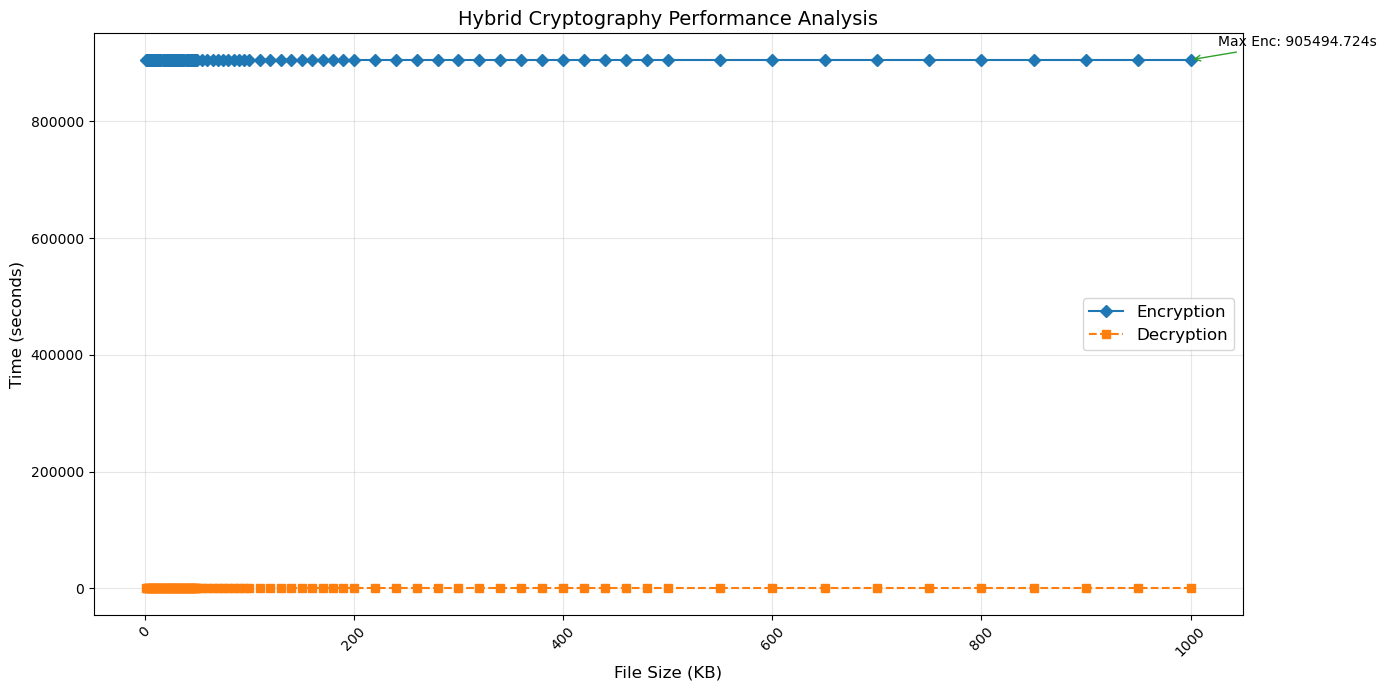

In [2]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import rsa, ec, padding
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

def generate_receiver_keys():
    private_rsa = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    public_rsa = private_rsa.public_key()
    private_ecc = ec.generate_private_key(ec.SECP256R1())
    public_ecc = private_ecc.public_key()
    return private_rsa, public_rsa, private_ecc, public_ecc

def encrypt_data(plaintext, public_rsa, public_ecc_receiver):
    start_time = time.perf_counter()
    sender_ecc_private = ec.generate_private_key(ec.SECP256R1())
    shared_secret = sender_ecc_private.exchange(ec.ECDH(), public_ecc_receiver)
    hkdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'hybrid_encryption')
    aes_key = hkdf.derive(shared_secret)
    encrypted_aes_key = public_rsa.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    key_time = time.perf_counter() - start_time
    iv = os.urandom(12)
    cipher = Cipher(algorithms.AES(aes_key), modes.GCM(iv))
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(plaintext) + encryptor.finalize()
    aes_time = time.perf_counter() - key_time
    return encrypted_aes_key, sender_ecc_private.public_key().public_bytes(
        encoding=serialization.Encoding.PEM, format=serialization.PublicFormat.SubjectPublicKeyInfo
    ), iv, encryptor.tag, ciphertext, key_time + aes_time

def decrypt_data(encrypted_aes_key, sender_ecc_public_bytes, iv, tag, ciphertext, private_rsa, private_ecc):
    start_time = time.perf_counter()
    aes_key = private_rsa.decrypt(
        encrypted_aes_key,
        padding.OAEP(mgf=padding.MGF1(hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    sender_ecc_public = serialization.load_pem_public_key(sender_ecc_public_bytes)
    shared_secret = private_ecc.exchange(ec.ECDH(), sender_ecc_public)
    hkdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'hybrid_encryption')
    derived_aes_key = hkdf.derive(shared_secret)
    if aes_key != derived_aes_key:
        raise ValueError("Security breach detected!")
    cipher = Cipher(algorithms.AES(derived_aes_key), modes.GCM(iv, tag))
    decryptor = cipher.decryptor()
    plaintext = decryptor.update(ciphertext) + decryptor.finalize()
    return plaintext, time.perf_counter() - start_time

def benchmark(sizes_kb=None, trials=5):
    if not sizes_kb:
        sizes_kb = list(range(1, 51)) + list(range(55, 105, 5)) + list(range(110, 205, 10)) + \
                    list(range(220, 505, 20)) + list(range(550, 1005, 50))
    results = []
    private_rsa, public_rsa, private_ecc, public_ecc = generate_receiver_keys()
    for size_kb in sizes_kb:
        size_bytes = size_kb * 1024
        print(f"Testing {size_kb} KB...")
        encrypt_times, decrypt_times = [], []
        for _ in range(trials):
            plaintext = os.urandom(size_bytes)
            enc_key, ecc_pub, iv, tag, ct, enc_time = encrypt_data(plaintext, public_rsa, public_ecc)
            encrypt_times.append(enc_time)
            _, decrypt_time = decrypt_data(enc_key, ecc_pub, iv, tag, ct, private_rsa, private_ecc)
            decrypt_times.append(decrypt_time)
        results.append({"Size (KB)": size_kb, "Encryption (s)": sum(encrypt_times)/trials, 
                        "Decryption (s)": sum(decrypt_times)/trials})
    return pd.DataFrame(results)

def plot_results(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df["Size (KB)"], df["Encryption (s)"], marker='D', linestyle='-', color='#1f77b4', label="Encryption")
    plt.plot(df["Size (KB)"], df["Decryption (s)"], marker='s', linestyle='--', color='#ff7f0e', label="Decryption")
    plt.title("Hybrid Cryptography Performance Analysis", fontsize=14)
    plt.xlabel("File Size (KB)", fontsize=12)
    plt.ylabel("Time (seconds)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    max_enc = df.loc[df["Encryption (s)"].idxmax()]
    plt.annotate(f"Max Enc: {max_enc['Encryption (s)']:.3f}s", 
                 (max_enc["Size (KB)"], max_enc["Encryption (s)"]),
                 xytext=(20, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='#2ca02c'))
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df = benchmark(trials=5)
    print("\n=== Benchmark Results ===")
    print(df.to_string(index=False, float_format="%.4f"))
    plot_results(df)
